In [1]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt  
from pylab import plt
plt.style.use('fivethirtyeight')

import ipywidgets as widgets
from ipywidgets import interact, FloatSlider, IntSlider, HBox, VBox, fixed

from IPython.display import IFrame
import mplleaflet


%matplotlib inline

### Reading data and sorting

We read our csv and sort by platenumber/bike_id and then by date.

In [2]:
path = '..//data/finaldata/last_data/muving_data.csv'
df = pd.read_csv(path)
df= df.sort_values(['plate','date'], ascending=[True,True]) 
#We'll be working on a copy of the dataframe
bikes = df.copy()
# Converting date to datetime opject
bikes["date"] = pd.to_datetime(bikes["date"])
bikes = bikes.set_index("date")
# fix charge values
bikes.loc[bikes["charge"] > 100, ["charge"]] = 100

bikes.head()

,plate,lat,lon,charge,range
date,,,,,
2018-09-27 04:53:00,8965KGR Scooter 125-B,41.420909,2.18103,65,42250.0
2018-09-27 04:58:00,8965KGR Scooter 125-B,41.420909,2.18103,65,42250.0
2018-09-27 05:03:00,8965KGR Scooter 125-B,41.420909,2.18103,65,42250.0
2018-09-27 05:08:00,8965KGR Scooter 125-B,41.420909,2.18103,65,42250.0
2018-09-27 05:13:00,8965KGR Scooter 125-B,41.420909,2.18103,65,42250.0


## Data Prep

#### Verifying Number of bikes


In [3]:
totaltime = bikes.index.max() - bikes.index.min()
print("Dataset contains geodata from {0} days from |{2}|  to |{1}| ".format(totaltime.days, bikes.index.max(), bikes.index.min() ))

Dataset contains geodata from 124 days from |2018-09-27 04:53:00|  to |2019-01-29 18:50:00| 


In [4]:
print("There are {} bikes in the system.".format(bikes['plate'].nunique()) )

NUM_BIKES = bikes['plate'].nunique()

There are 388 bikes in the system.


In [5]:
bikes.describe()

,lat,lon,charge,range
count,7.546610e+06,7.546610e+06,7.546610e+06,7.546610e+06
mean,4.140623e+01,2.160728e+00,5.823943e+01,3.785563e+04
std,2.300476e-02,2.919541e-02,2.483648e+01,1.614371e+04
min,4.132863e+01,2.095643e+00,0.000000e+00,0.000000e+00
25%,4.139013e+01,2.135782e+00,3.600000e+01,2.340000e+04
50%,4.140616e+01,2.160130e+00,5.800000e+01,3.770000e+04
75%,4.142645e+01,2.185785e+00,8.100000e+01,5.265000e+04
max,4.145226e+01,2.222513e+00,1.000000e+02,6.500000e+04


In [6]:
bikes.head()

,plate,lat,lon,charge,range
date,,,,,
2018-09-27 04:53:00,8965KGR Scooter 125-B,41.420909,2.18103,65,42250.0
2018-09-27 04:58:00,8965KGR Scooter 125-B,41.420909,2.18103,65,42250.0
2018-09-27 05:03:00,8965KGR Scooter 125-B,41.420909,2.18103,65,42250.0
2018-09-27 05:08:00,8965KGR Scooter 125-B,41.420909,2.18103,65,42250.0
2018-09-27 05:13:00,8965KGR Scooter 125-B,41.420909,2.18103,65,42250.0


## Estimating number of rides and kilometers ridden based on Geodata

The scraper pulled data from all bikes available every 5 minutes. Thus the bikes currently in use will not appear in our data until they are parked and the driver ends the ride. 


We are trying to estimate the kilometers and minutes ridden by filtering out those rows where the [*Vincenty distance*](https://en.wikipedia.org/wiki/Vincenty's_formulae) from the position of a bike at a certain time to the position of that bike at the next time we get data. 

 Bikes not in use will have a negligible distance between their positions in 5 minutes time. However bikes currently being ridden will have their first position recorded, and the next position will be recorded after X minutes. Those X minutes will approximately (~+-1 minute) be the minutes the bikes were being used and the distance will be the distance ridden.


#### Margin of Error
In order to do that we need to find a threshold of distance variation as we can get slightly different geoposition lectures from bikes that are currently parked and not moving.


#### Estimations

Mean GPS error on open sky has been said by ION and the US government to be between 4.9 and 5 meters. 

However we must take into consideration the vast amount of interferences a GPS device is under in an urban environment like Barcelona. 
Following the empirical study by the *University of Applied Sciences Zittau*, Germany it was concluded that a positional error of **28 meters** should be accounted for in any location-based application. 

#### Threshold

We will set the threshold at 0.03 km

#### References
- [Institute of Navigation](https://www.ion.org/publications/abstract.cfm?articleID=13079)
- [Official U.S. Government Global Positioning System Information](https://www.gps.gov/systems/gps/performance/accuracy/)
- [Field trial on GPS Accuracy in a medium size city: The influence of built-up, University of Applied Sciences Zittau/Görlitz, Germany](http://wpnc.net/fileadmin/WPNC06/Proceedings/30_Field_trial_on_GPS_Accuracy_in_a_medium_size_city_The_influence_of_builtup.pdf)



### Distance computation

In [7]:
# testing accuracy of our homemade geofuncs 
from numpy import cos, arcsin, sqrt

from geopy import distance
from geofuncs import geodesic_distance # See module geofuncs.py

# optimizing function reducing number of calls to compute extensive trig functions.
def geodesic_optimized(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2.0
    return 12742.0 * arcsin(sqrt(a))

position1 = (42.122, 2.123)
position2 = (41.234, 2.342)
print("homemade geodesic: {} \n geopy: {} \n optimized: {}".format(geodesic_distance(*position1,*position2),
                                                  distance.distance(position1,position2), geodesic_optimized(*position1, *position2)))

homemade geodesic: 100.43043161241513 
 geopy: 100.29905506043818 km 
 optimized: 100.4021362448805


In [8]:
%%timeit 
distance.distance(position1, position2)

207 µs ± 2.99 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
%%timeit
geodesic_distance(*position1, *position2)

13.4 µs ± 81.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [10]:
%%timeit
geodesic_optimized(*position1, *position2)

9.16 µs ± 949 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [11]:
from sklearn.neighbors import DistanceMetric
    
dist = DistanceMetric.get_metric('haversine')

# example data
lat1, lon1 = position1
lat2, lon2 = position2
lat1,lat2,lon1,lon2 = map(np.radians, [ lat1, lat2, lon1, lon2,])

X = np.array([[lat1, lon1],
     [lat2, lon2]])
kms = 6372.795477598

print(kms * dist.pairwise(X)[0,1])

100.43043161240702


In [ ]:
%%timeit
kms * dist.pairwise(X)

#### Note that our geodesic function performs more than 10 times faster than geopy's 
Yet we only get a 0.1% error which will not pose any problem in our estimations.

**The optimized version runs more than 23 times faster**

### Back to our data

In [12]:

# homemade geodesic optimized implementation 
bikes["lat_shifted"] = bikes.shift(1).lat.replace(np.nan, method='bfill')
bikes["lon_shifted"] = bikes.shift(1).lon.replace(np.nan, method='bfill')


bikes["ride_distance"] = geodesic_optimized(bikes.lat, bikes.lon, bikes.lat_shifted, bikes.lon_shifted)

# geopy slow implementation
# bikes["coords"] = list(zip(bikes["lat"], bikes["lon"]))
# bikes["coordsshifted"] = list(zip(bikes["lat_shifted"], bikes["lon_shifted"]))





#### Cleaning new ride distance data

In [13]:
bikes.loc[bikes["ride_distance"].isnull(), "ride_distance"] = 0.0

# Clean the new data by filtering out the records with less than 50 meter distance traveled.
THRESHOLD = 0.05
bikes.loc[bikes["ride_distance"] < THRESHOLD , ["ride_distance"]] = 0

# Clean shifted values for different bike ids / plates
bikes.loc[bikes.plate != bikes.shift(1).plate, "ride_distance"] = 0

print( "Estimated number of rides: {}".format((bikes.ride_distance.loc[bikes["ride_distance"] > 0]).count()))

Estimated number of rides: 72194


## Estimating ride time

In [14]:
bikes["dates"] = bikes.index
bikes["ride_minutes"] = bikes.index - bikes.shift(1).dates.replace(pd.NaT, method="bfill")
#bikes['ride_minutes2'] = df.groupby('plate')['date'].diff().fillna(0)


#### Cleaning new ride time data

In [15]:
#bikes.loc[bikes["ride_distance"] < threshold, ["ride_minutes"]] = pd.to_timedelta(0)
bikes.loc[(bikes.dates - bikes.shift(1).dates)> pd.to_timedelta("3 hours"), "ride_distance"] = 0
#bikes.loc[(bikes.dates - bikes.shift(1).dates)> pd.to_timedelta("3 hours"), "ride_minutes"] = pd.to_timedelta(0)

# Drop preprocessing columns
bikes = bikes [["plate", "lat", "lon", "range","charge", "ride_distance", "ride_minutes" ]]


### Battery and Range Estimation

In [16]:
print( "Estimated number of rides: {} ".format((bikes.ride_distance.loc[bikes["ride_distance"] > 0]).count()))
print("Of those Charge increased: {} ".format(bikes.ride_minutes.loc[(bikes["ride_distance"]>0) & (bikes.shift(1).charge < bikes["charge"] ) ].count()) )



Estimated number of rides: 68762 
Of those Charge increased: 4599 


The bikes that travelled a distance greater than our threshold yet had their battery charge increased, we are going to assume that are being transported by truck to the repair shop or to a more active location, thus we'll filter those records out.

In [17]:
bikes.loc[(bikes["ride_distance"]>0) & (bikes.shift(1).charge < bikes["charge"] ) , "ride_distance"] = 0

# filter out  hours of movement between 3am and 6am
bikes.loc[(bikes.index.hour < 6) & (bikes.index.hour > 3), "ride_distance" ] = 0

#Last step,  ride minutes are equaled to zero for rows with no rides , ride_distance == 0
bikes.loc[bikes["ride_distance"] < THRESHOLD, ["ride_minutes"]] = pd.to_timedelta(0)



In [18]:
print( "Estimated number of rides: {}".format((bikes.ride_distance.loc[bikes["ride_distance"] > 0]).count()))


bikes.head()

Estimated number of rides: 63300


,plate,lat,lon,range,charge,ride_distance,ride_minutes
date,,,,,,,
2018-09-27 04:53:00,8965KGR Scooter 125-B,41.420909,2.18103,42250.0,65,0.0,0 days
2018-09-27 04:58:00,8965KGR Scooter 125-B,41.420909,2.18103,42250.0,65,0.0,0 days
2018-09-27 05:03:00,8965KGR Scooter 125-B,41.420909,2.18103,42250.0,65,0.0,0 days
2018-09-27 05:08:00,8965KGR Scooter 125-B,41.420909,2.18103,42250.0,65,0.0,0 days
2018-09-27 05:13:00,8965KGR Scooter 125-B,41.420909,2.18103,42250.0,65,0.0,0 days


#### Groupbys

- by rideminutes
- by charge
- by aggregating minutes everyday
- by aggregating number of rides
- by aggregating kilometers

Text(0, 0.5, 'Daily Revenue [EUR]')

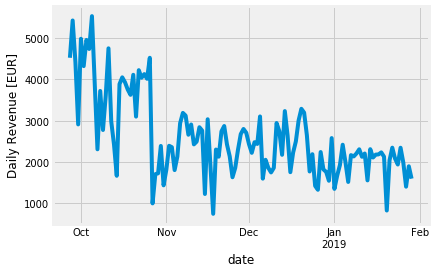

In [19]:
bikes_daily_distance = bikes["ride_distance"].resample("D").sum()

COST_PER_MINUTE = 0.22
bikes_daily_revenue = bikes["ride_minutes"].resample("D").sum().apply(lambda x: COST_PER_MINUTE * x.total_seconds()/60 )
bikes_daily_revenue.plot()
plt.ylabel("Daily Revenue [EUR]")

In [20]:
mean_kms_ridden = bikes["ride_distance"].resample("D").sum().mean()
mean_time_ridden = bikes["ride_minutes"].resample("D").sum().mean()
mean_revenue = bikes_daily_revenue.mean()



print( "Mean time ridden in a day: {:.2f} hours , about {} days".format(mean_time_ridden.total_seconds()/3600,mean_time_ridden.days) )
print("Mean kilometers ridden in a day: {:.2f} km".format(mean_kms_ridden))
print("Estimated mean daily revenue: {:.2f} EUR".format(mean_revenue))

Mean time ridden in a day: 196.70 hours , about 8 days
Mean kilometers ridden in a day: 1257.25 km
Estimated mean daily revenue: 2596.49 EUR


# Weather Data Prep

In [21]:
weather = pd.read_csv("../data/mldata/bcn_weather.csv", delimiter=";")
weather = weather.rename(columns={"FECHA": "date", "TMEDIA": "temp", "PRECIPITACION":"rain", 
                                  "TMIN":"min_temp", "TMAX":"max_temp", "SOL":"sun", "RACHA":"max_wind"})
weather["date"] = pd.to_datetime(weather.date)
weather = weather.set_index("date")
weather = weather["september 27 2018":"january 29 2019"].copy()
weather.loc[weather.rain == "Ip", "rain"] = 0.0
weather.rain =weather.rain.astype("float")
weather = weather[["temp","rain", "min_temp", "max_temp", "max_wind" ]].copy()
weather = weather.fillna(method="ffill")

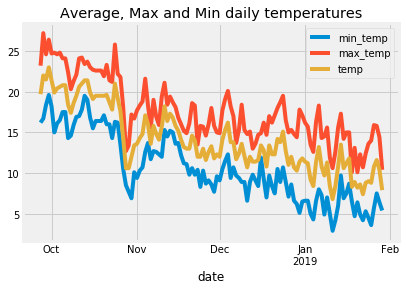

In [22]:
weather.plot(y=["min_temp","max_temp", "temp"] ,title="Average, Max and Min daily temperatures")

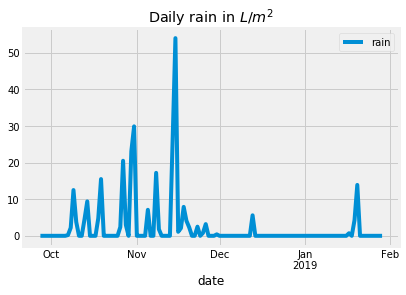

In [23]:
weather.plot(y= "rain", title="Daily rain in $L/m^2$")

In [24]:
df_daily = pd.DataFrame(bikes_daily_revenue)
df_daily = pd.concat([df_daily, weather ],axis=1)
df_daily = df_daily.rename(columns={"ride_minutes":"revenue"})
df_daily.head()


,revenue,temp,rain,min_temp,max_temp,max_wind
date,,,,,,
2018-09-27,4521.66,19.7,0.0,16.2,23.2,6.1
2018-09-28,5424.76,22.0,0.0,16.7,27.2,8.9
2018-09-29,4415.40,21.5,0.0,18.4,24.6,10.0
2018-09-30,2907.74,23.0,0.0,19.6,26.4,11.4
2018-10-01,4981.68,21.4,0.0,18.2,24.7,9.7


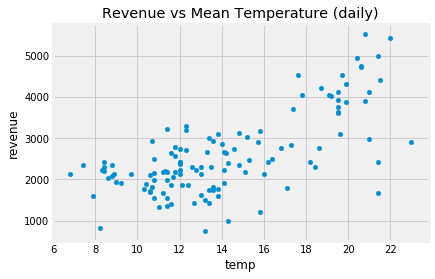

In [25]:
df_daily.plot(x= "temp", y = "revenue", kind="scatter", title= "Revenue vs Mean Temperature (daily)")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12273d828>,
      dtype=object)

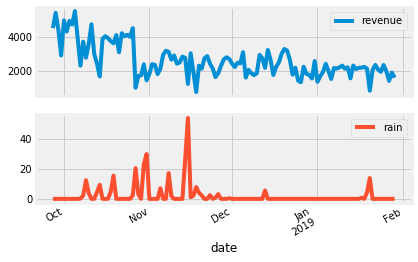

In [26]:
df_daily[["revenue", "rain"]].plot(subplots=True)

Text(0.5, 1.0, 'Estimated revenue vs Daily temperature')

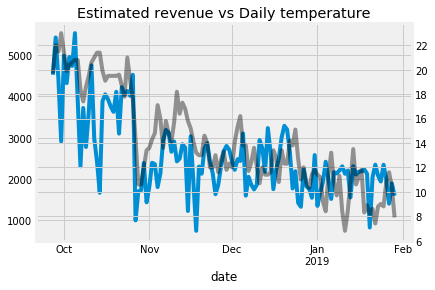

In [27]:
ax1 = df_daily["revenue"].plot()

ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
df_daily["temp"].plot(ax=ax2,cmap="cubehelix", alpha=0.4)
plt.title("Estimated revenue vs Daily temperature")


In [28]:
# Adding weekday flags as we supposed bikes are not used uniformly 
_days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    df_daily[_days[i]] = (df_daily.index.dayofweek == i).astype(float)
    
# Dry days feature
df_daily["norain"] =(df_daily["rain"] == 0).astype(int)
    

In [29]:
df_daily["mean_lat"] = bikes["lat"].resample("D").mean()
df_daily["mean_lon"] = bikes["lon"].resample("D").mean()

In [30]:
df_daily.head()

,revenue,temp,rain,min_temp,max_temp,max_wind,Mon,Tue,Wed,Thu,Fri,Sat,Sun,norain,mean_lat,mean_lon
date,,,,,,,,,,,,,,,,
2018-09-27,4521.66,19.7,0.0,16.2,23.2,6.1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,41.409074,2.161300
2018-09-28,5424.76,22.0,0.0,16.7,27.2,8.9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,41.409173,2.163294
2018-09-29,4415.40,21.5,0.0,18.4,24.6,10.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,41.409468,2.163879
2018-09-30,2907.74,23.0,0.0,19.6,26.4,11.4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,41.410635,2.165276
2018-10-01,4981.68,21.4,0.0,18.2,24.7,9.7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,41.408521,2.168012


# Predictions 

### Model Selection

Now that we have all our features we will test several models.

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

import xgboost

In [32]:
def compute_score(model, X, y):
    crossval = cross_val_score(model, X, y, cv = 5)
    return np.mean(crossval)

In [48]:
shuffled = df_daily.sample(frac=1, random_state=42)
#shuffled = df_daily
y = shuffled["revenue"].values
X = shuffled.drop(["revenue","mean_lat", "mean_lon"], axis=1).values
#X2 = shuffled[["temp", "norain"]].values


Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, train_size=0.4, test_size = 0.6)


In [53]:
model3 = LinearRegression(fit_intercept=False)
xgb2.fit(Xtrain, ytrain)

arraypred = df_daily["revenue"].iloc[:50].values
arraypred = np.hstack((arraypred, xgb2.predict(Xtest)))

df_daily['predictedtest'] = arraypred

In [54]:
df_daily["crossval"] = cross_val_predict(model3,X,y,cv=5)

0.7296753985317704


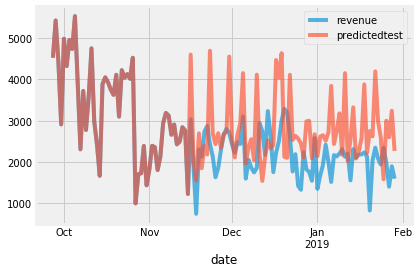

In [55]:
df_daily[["revenue", "predictedtest"]].plot(alpha=0.65)
print(np.mean(cross_val_score(model3, X,y, cv=5)))

### Testing Model scores

In [56]:
elastic = ElasticNet()
ridge = Ridge(alpha=0.8)
linear = LinearRegression(fit_intercept=False)
svr = SVR(gamma="auto", kernel="linear", cache_size= 500, C=0.9)
ada = AdaBoostRegressor(random_state=42)
forest = RandomForestRegressor(n_estimators=1000, random_state=42)
gradient = GradientBoostingRegressor(max_depth=2,n_estimators=1000, random_state=42)
xgb = xgboost.XGBRegressor(n_estimators=55, random_state=42)
models = [elastic, ridge, linear, svr, ada, forest, gradient, xgb]
for model in models:
    #model.fit(Xtrain, ytrain)
    print("Score of: ",model.__class__, cross_val_score(model,X, y, cv=5).mean())

Score of:  <class 'sklearn.linear_model.coordinate_descent.ElasticNet'> 0.6851080887786921
Score of:  <class 'sklearn.linear_model.ridge.Ridge'> 0.7341866243367321
Score of:  <class 'sklearn.linear_model.base.LinearRegression'> 0.7296753985317704
Score of:  <class 'sklearn.svm.classes.SVR'> 0.5740483877062477
Score of:  <class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'> 0.6532781107918926
Score of:  <class 'sklearn.ensemble.forest.RandomForestRegressor'> 0.7221773594824035
Score of:  <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'> 0.6821382089835109
Score of:  <class 'xgboost.sklearn.XGBRegressor'> 0.7150805121899582


We then calculate cross validation scores randomizing the dataframe values extracted.

In [39]:
scores_dic = {}
for i in np.random.randint(1000, size=10):
    shuffled_random = df_daily.sample(frac=1, random_state=i)
    y_shuffled = shuffled_random["revenue"].values
    X_shuffled = shuffled_random.drop(["revenue","mean_lat", "mean_lon"], axis=1).values
    
    for model in models:
        #model.fit(Xtrain, ytrain)
        if str(model.__class__) not in scores_dic:
            scores_dic[str(model.__class__)] = []
            
        scores_dic[str(model.__class__)].append( cross_val_score(model,X_shuffled, y_shuffled, cv=5).mean())
        #print("Score of: ",model.__class__, cross_val_score(model,X, y, cv=6).mean())
        
for key,score in scores_dic.items():
    print (key, np.mean(scores_dic[key]))

<class 'sklearn.linear_model.coordinate_descent.ElasticNet'> 0.6971904638594001
<class 'sklearn.linear_model.ridge.Ridge'> 0.7493608678025148
<class 'sklearn.linear_model.base.LinearRegression'> 0.7419753233821528
<class 'sklearn.svm.classes.SVR'> 0.6290804335155477
<class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'> 0.7326883414024385
<class 'sklearn.ensemble.forest.RandomForestRegressor'> 0.7570902993697062
<class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'> 0.74181170476506
<class 'xgboost.sklearn.XGBRegressor'> 0.7635734377334868


In [60]:
for model in models:
    #model.fit(Xtrain, ytrain)
    print("Score of: ",model.__class__, cross_val_score(model,X, y, cv=KFold(n_splits=3, shuffle=False, random_state=42)).mean())

Score of:  <class 'sklearn.linear_model.coordinate_descent.ElasticNet'> 0.7148105514473148
Score of:  <class 'sklearn.linear_model.ridge.Ridge'> 0.771477798134394
Score of:  <class 'sklearn.linear_model.base.LinearRegression'> 0.7680307178289206
Score of:  <class 'sklearn.svm.classes.SVR'> 0.6609026081729209
Score of:  <class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'> 0.7262894590909769
Score of:  <class 'sklearn.ensemble.forest.RandomForestRegressor'> 0.7802218796265245
Score of:  <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'> 0.7393167459834954
Score of:  <class 'xgboost.sklearn.XGBRegressor'> 0.7752493477104633


In [40]:
xgb2 = xgboost.XGBRegressor(random_state=42,n_estimators=55)
xgb2.fit(X,y)
xgb2.feature_importances_

array([0.46273178, 0.0382294 , 0.07368329, 0.11023171, 0.04137601,
       0.02610879, 0.        , 0.02973354, 0.02737512, 0.03265211,
       0.03011007, 0.12776822, 0.        ], dtype=float32)

In [41]:
# Preprocess
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xscaled = scaler.fit_transform(X)
yscaled = scaler.fit_transform(y.reshape(len(y),1))
testmodel = make_pipeline(MinMaxScaler(), PolynomialFeatures(3), LinearRegression(fit_intercept=False))

testmodel2 = make_pipeline(MinMaxScaler(),SVR(gamma="auto", kernel="linear", cache_size= 2000, C=0.9))

svr2 = SVR(kernel="linear", degree=2, C=100, epsilon=0.1, gamma="auto", cache_size=500)


cross_val_score(svr2, X, y, cv=5).mean()

0.6208125027187704

## Heat Map (CARTO)

We create a new dataframe (bike1) to store only relevant data for exporting and visualizing in CARTO.

In [ ]:
bike_carto = df.loc[:, ['date', 'lat', 'lon', 'plate']]

In [ ]:
import cartoframes
from cartoframes import Layer, BaseMap, styling

BASE_URL = 'https://pggmrt.carto.com'
API_KEY = '8f901e65b3fe1c9d5837d0ea09fd7f8143e83b51'

cc = cartoframes.CartoContext(base_url=BASE_URL,
                              api_key=API_KEY)

cc.write(bike_carto, 'muv_data')

#cc.map(Layer('bikes_data', time='date', color='net'))

### Heat map

Extract from an animated heatmap over the course of 3 days.
Full interactive map available at https://pggmrt.carto.com

![Animated](../CARTO_imgs/muv-heatmap.gif)


# Clustering
We will perform several spatial clustering analysis algorithms that could be used to optimize and divide properly the city into a determined number of zones, one for each employee in charge of charging the bikes. Thus the number of clusters would be the number of employees in the charging team.

## DBScan 

The DBScan algorithm is supposed to be the most prevalent in cluster analysis on geodata. Using a haversine metric and inputting the kilometers .. etc



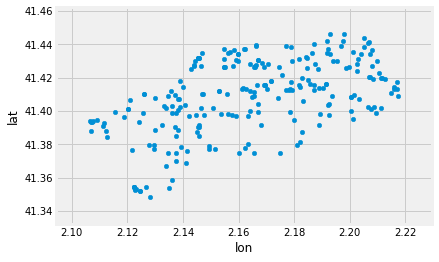

In [61]:
# get a random sample of a night time when the charging team starts operating
dfinstant = bikes["2018-11-13 00:51"]
dfinstant[[ "lat", "lon"]].plot(x = "lon", y="lat",kind="scatter")

In [62]:
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

# get numpyarray from dataframe
X = dfinstant[['lon', 'lat']].values

Number of clusters: 10


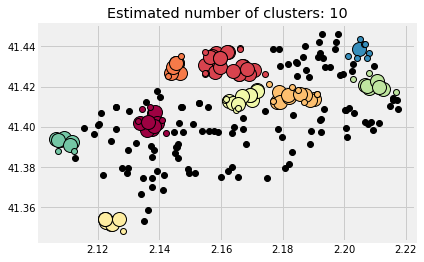

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x123f8df28>)

In [63]:
def dbscan_cluster(X, kms, minsamples):
    kms_per_radian = 6371.0088
    epsilon = kms / kms_per_radian

    dbscan = DBSCAN(eps=epsilon, min_samples=minsamples, algorithm='auto', metric='haversine')
    dbscan.fit(np.radians(X))
    cluster_labels = dbscan.labels_
    core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_samples_mask[dbscan.core_sample_indices_] = True

    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([X[cluster_labels == n] for n in range(num_clusters)])
    print('Number of clusters: {}'.format(num_clusters))
    return cluster_labels, core_samples_mask

  
def plot_dbscan(X, cluster_labels, core_samples_mask):
    unique_labels = set(cluster_labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    fig, ax = plt.subplots()
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black color for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (cluster_labels == k)

        xy = X[class_member_mask & core_samples_mask]
        ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    ax.set_title('Estimated number of clusters: %d' % len(set(cluster_labels)))
    plt.show()
    return fig,ax

slider1 = FloatSlider(min=0.1, max=1.5, step=0.05, value=0.6, continuous_update=False)
slider2 = IntSlider(min=1, max=40, step=1, value=7, continuous_update=False)

@interact(kms=slider1, minsamples= slider2)
def dbscan_full(kms, minsamples):
    global X
    global fig_dbscan, ax_dbscan
    #kms = 0.7
    #minsamples = 5
    fig_dbscan, ax_dbscan = plot_dbscan (X, *dbscan_cluster(X, kms, minsamples))

    return fig_dbscan, ax_dbscan


In [64]:
# Using mplleaflet we overlay our clustered data into an openstreet map.

mplleaflet.display(fig=fig_dbscan)

/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## K - Means Clustering

In [65]:
from sklearn.cluster import KMeans

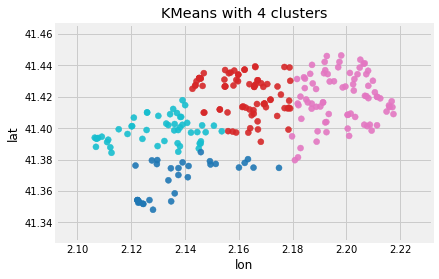

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1241bc748>)

In [66]:
slider3 = IntSlider(min=1, max=20, step=1, value=4, continuous_update=False)
@interact(n_clusters=slider3)
def plot_KMeans(n_clusters):  
    global X, fig_kmeans, ax_kmeans
    kmeans = KMeans(n_clusters)  
    kmeans.fit(X )  
    
    fig_kmeans, ax_kmeans = plt.subplots( )
    ax_kmeans.scatter(X[:,0],X[:,1], c=kmeans.labels_, cmap='tab10',  marker="o", alpha=0.9) 
    ax_kmeans.set_xlabel("lon")
    ax_kmeans.set_ylabel("lat")
    ax_kmeans.set_title("KMeans with {} clusters".format(n_clusters))
    plt.show()
    return fig_kmeans, ax_kmeans

In [67]:
mplleaflet.display(fig=fig_kmeans)

/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Analysis 

### Battery charge distribution

Text(0, 0.5, 'Frequency')

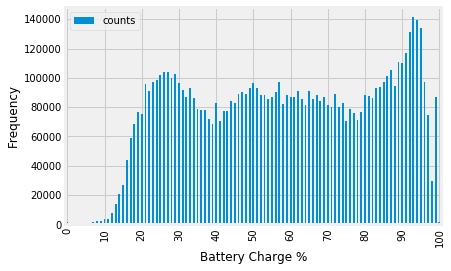

In [68]:
charge_group = bikes.groupby(["charge"]).count().loc[:,["plate"]].rename(columns={"plate": "counts"})
xticklabels = [str(x) for x in range(0,110,10)]
charge_group.plot( kind="bar", use_index=False, )
_ =plt.xticks(ticks= range(0,110,10), labels=xticklabels)
plt.xlabel("Battery Charge %")
plt.ylabel("Frequency")

### Groupbyss


### Plotting estimate revenue + average minute ride

In [ ]:
dfminutes = bikes.groupby("ride_minutes").plot()
#dfminutes.plot(kind='bar', title=' Time Frequency of rides ', legend=False)
#ADD SCATTER REVENUE /CANDLESTICK MAX MIN MINUTES
#dfminutes.plot()

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


We then create a new dataframe only containing the rows representing each ride.

We add a day of the week column to our rides datframe for further analysis

In [ ]:
bikes['dayofweek'] = bikes.index.day

In [ ]:
bike_rides.head()

#### Hourly Rides

In [ ]:
hourly = bike_rides['date'].dt.hour.value_counts().sort_index().plot(kind='bar', title='Hourly frequency of 5 minute Rides ')
plt.xlabels("Hours")

#### Weekly Rides

In [ ]:
weekly = bike_rides['dayofweek'].value_counts(sort=False)


In [ ]:
weekly =weekly.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',  'Sunday'])
weekly.plot(kind='bar', title='Weekly frequency of Rides ')